In [1]:
import pandas as pd
import os
from os.path import join as ospj
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import json
from tqdm import tqdm
from scipy.cluster.hierarchy import linkage, leaves_list

# Make Georgia the font for all plots
plt.rcParams['font.family'] = 'Georgia'

# Specify WM and GM atlases
wm_atlas = "HCP1065"
gm_atlas = "4S156"

# Define directory to GAM outputs
gam_outputs_wm_dir = f"/mnt/sauce/littlab/users/mjaskir/structural_tractometry/derivatives/gam/outputs/tracts/{wm_atlas}"
gam_outputs_gm_dir = f"/mnt/sauce/littlab/users/mjaskir/structural_tractometry/derivatives/gam/outputs/regions/{gm_atlas}"

# Define directory to save z-score summaries
gam_outputs_group_summaries_dir = "/mnt/sauce/littlab/users/mjaskir/structural_tractometry/derivatives/gam/outputs/"
if not os.path.exists(gam_outputs_group_summaries_dir):
    os.makedirs(gam_outputs_group_summaries_dir)

# Measures files
measures_json_path = "/mnt/sauce/littlab/users/mjaskir/structural_tractometry/data/metadata/scalar_labels_to_filenames.json"
colors_json_path = "/mnt/sauce/littlab/users/mjaskir/structural_tractometry/data/metadata/scalar_labels_to_colors.json"
human_labels_json_path = "/mnt/sauce/littlab/users/mjaskir/structural_tractometry/data/metadata/scalar_labels_to_human.json"

# Load clinical data
clinical_file = "/mnt/sauce/littlab/users/mjaskir/structural_tractometry/derivatives/metadata/clinical_penn_epilepsy_qsirecon.csv"
clinical_df = pd.read_csv(clinical_file)

# Load wm metadata (Fields: label, name, hemi, type)
wm_metadata_file = "/mnt/sauce/littlab/users/mjaskir/structural_tractometry/data/atlases/HCP1065/HCP1065_tract_metadata.csv"
wm_metadata_df = pd.read_csv(wm_metadata_file)

# Load gm metadata (Fields: index, label, network_label, network_label_17network) # Reminder: subcortical, thalamic, and cerebellar regions do not have network assignments
gm_metadata_file = "/mnt/sauce/littlab/users/mjaskir/structural_tractometry/data/atlases/4S/atlas-4S156Parcels_dseg.tsv"
gm_metadata_df = pd.read_csv(gm_metadata_file, sep="\t")

# Add a hemi column
gm_metadata_df["hemi"] = gm_metadata_df["label"].apply(lambda x: "left" if x.startswith("LH") else "right" if x.startswith("RH") else "bilateral")

# Remove cranial nerve and bilateral tracts
wm_metadata_df = wm_metadata_df[~wm_metadata_df["label"].str.startswith("CN")]
wm_metadata_df = wm_metadata_df[wm_metadata_df["hemi"] != "bilateral"]

wm_rois = wm_metadata_df["label"].tolist()
gm_rois = gm_metadata_df["label"].tolist()

global wm_metadata_df, gm_metadata_df, wm_rois, gm_rois

# Groups

In [ ]:
# Create a dictionary with keys as group names and values as lists of 'sub' values
sub_groups = {}

# Seizure lateralization
lat_options = ["left", "right", "bilateral", "left > right", "right > left", "generalized", "inconclusive"]
for lat in lat_options:
    sub_groups[f"seizure_lateralization_{lat}"] = clinical_df.loc[clinical_df["seizure_lateralization"] == lat, "sub"].tolist()

# Seizure localization
loc_options = ["frontal", "temporal", "parietal", "occipital", "generalized", "central", "multifocal", "nonlocalizable", "insular"]
for loc in loc_options:
    sub_groups[f"seizure_localization_{loc}"] = clinical_df.loc[clinical_df["seizure_localization"] == loc, "sub"].tolist()

# Seizure lateralization and localization combinations
combos = [
    ("left_temporal", ("temporal", "left")),
    ("right_temporal", ("temporal", "right"))
]
for label, (loc, lat) in combos:
    sub_groups[label] = clinical_df.loc[
        (clinical_df["seizure_localization"] == loc) & (clinical_df["seizure_lateralization"] == lat),
        "sub"
    ].tolist()

# Combine both to temporal
sub_groups["temporal"] = sub_groups["left_temporal"] + sub_groups["right_temporal"]

# Resection or ablation
# for lat in ["left", "right"]:
#     key = f"resection_or_ablation_{lat}"
#     sub_groups[key] = clinical_df.loc[clinical_df["intervention_laterality"] == lat, "sub"].tolist()

# # Good outcomes at 1 year
# good1 = clinical_df["ilae_category_pecclinical"].isin(["1a", "1b", "2"])
# for lat in ["left", "right"]:
#     key = f"good_outcome_1yr_{lat}"
#     sub_groups[key] = clinical_df.loc[good1 & (clinical_df["intervention_laterality"] == lat), "sub"].tolist()

# # Good outcomes at 2 years
# good2 = clinical_df["ilae_category_2_pecclinical"].isin(["1a", "1b", "2"])
# for lat in ["left", "right"]:
#     key = f"good_outcome_2yr_{lat}"
#     sub_groups[key] = clinical_df.loc[good2 & (clinical_df["intervention_laterality"] == lat), "sub"].tolist()

# # Temporal intervention with good outcomes at 1 year
# for lat in ["left", "right"]:
#     key = f"temporal_good_outcome_1yr_{lat}"
#     sub_groups[key] = clinical_df.loc[
#         (clinical_df["intervention_lobe"] == "temporal") &
#         good1 &
#         (clinical_df["intervention_laterality"] == lat),
#         "sub"
#     ].tolist()

# # Temporal intervention with good outcomes at 2 years
# for lat in ["left", "right"]:
#     key = f"temporal_good_outcome_2yr_{lat}"
#     sub_groups[key] = clinical_df.loc[
#         (clinical_df["intervention_lobe"] == "temporal") &
#         good2 &
#         (clinical_df["intervention_laterality"] == lat),
#         "sub"
#     ].tolist()

# Neuromodulation
sub_groups["neuromodulation"] = clinical_df.loc[
    clinical_df["intervention_type"].isin(["RNS", "VNS", "DBS"]),
    "sub"
].tolist()

In [3]:
def get_input_specs(input_data_type="all"):
    """
    Returns roi_dict, stats, and measures based on the input_data_type.
    """
    stats = ["mean"]
    measures_all = list(json.load(open(measures_json_path)).keys())
    wm_test_rois = ["F_L", "F_R", "UF_L", "UF_R", "C_PH_L", "C_PH_R", "ILF_L", "ILF_R"]
    gm_test_rois = ["LH_Hippocampus", "RH_Hippocampus", "LH_Amygdala", "RH_Amygdala"]

    if input_data_type == "all":
        roi_dict = {
            "wm": {"dir": gam_outputs_wm_dir, "rois": wm_rois},
            "gm": {"dir": gam_outputs_gm_dir, "rois": gm_rois}
        }
        measures = measures_all
    elif input_data_type == "gm":
        roi_dict = {"gm": {"dir": gam_outputs_gm_dir, "rois": gm_rois}}
        measures = measures_all
    elif input_data_type == "wm":
        roi_dict = {"wm": {"dir": gam_outputs_wm_dir, "rois": wm_rois}}
        measures = measures_all
    elif input_data_type == "test":
        roi_dict = {
            "wm": {"dir": gam_outputs_wm_dir, "rois": wm_test_rois},
            "gm": {"dir": gam_outputs_gm_dir, "rois": gm_test_rois}
        }
        measures = ["dti_md"]
    elif input_data_type == "test_gm":
        roi_dict = {"gm": {"dir": gam_outputs_gm_dir, "rois": gm_test_rois}}
        measures = ["dti_md"]
    elif input_data_type == "test_wm":
        roi_dict = {"wm": {"dir": gam_outputs_wm_dir, "rois": wm_test_rois}}
        measures = ["dti_md"]
    else:
        raise ValueError(f"Unknown input_data_type: {input_data_type}")
    return roi_dict, stats, measures

In [4]:
def get_roi_zscores(
    roi_dict, stats, measures, subs=None, method="mean", z_type="abs", networks=False, ipsi=None, title=None
):
    """
    For each subject, returns a DataFrame of mean (or sum) z-scores (across measures and stats) for each ROI.
    Returns a dictionary: {sub: DataFrame}, where each DataFrame has columns ['tissue', 'roi', 'mean_z'].
    """
    import warnings

    if method not in ["sum", "mean"]:
        raise ValueError(f"Unknown method: {method}. Only 'sum' and 'mean' are allowed.")
    if z_type not in ["raw", "abs"]:
        raise ValueError(f"Unknown z_type: {z_type}. Only 'raw' and 'abs' are allowed.")

    # Determine which subjects to use
    all_subs = set()
    if subs is not None:
        all_subs = set(subs)
    else:
        # If subs is None, collect all subjects from all files
        for tissue_type, info in roi_dict.items():
            gam_outputs_dir = info["dir"]
            rois = info["rois"]
            for roi in rois:
                for stat in stats:
                    for measure in measures:
                        gam_outputs_path = ospj(gam_outputs_dir, roi, f"{roi}_{stat}_{measure}_gam.csv")
                        if not os.path.exists(gam_outputs_path):
                            continue
                        try:
                            gam_outputs_df = pd.read_csv(gam_outputs_path)
                            gam_outputs_df = gam_outputs_df[gam_outputs_df["group"] == "penn_epilepsy"]
                            all_subs.update(gam_outputs_df["sub"].unique())
                        except Exception:
                            continue

    all_subs = sorted(list(all_subs))

    # Nested dict: subj -> tissue_type -> roi -> stat -> measure -> z
    subj_zscores = {sub: {} for sub in all_subs}

    # For each subject, for each tissue_type, roi, stat, measure, store z-score
    for tissue_type, info in roi_dict.items():
        gam_outputs_dir = info["dir"]
        rois = info["rois"]
        print(f"Summarizing measures for {tissue_type}")
        for roi in tqdm(rois):
            for stat in stats:
                for measure in measures:
                    gam_outputs_path = ospj(gam_outputs_dir, roi, f"{roi}_{stat}_{measure}_gam.csv")
                    if not os.path.exists(gam_outputs_path):
                        continue
                    try:
                        gam_outputs_df = pd.read_csv(gam_outputs_path)
                        gam_outputs_df = gam_outputs_df[gam_outputs_df["group"] == "penn_epilepsy"]
                        gam_outputs_df = gam_outputs_df[gam_outputs_df["sub"].isin(all_subs)]

                        for _, row in gam_outputs_df.iterrows():
                            sub = row["sub"]
                            if "z" not in gam_outputs_df.columns:
                                continue
                            z_val = row["z"]
                            subj_zscores[sub].setdefault(tissue_type, {}).setdefault(roi, {}).setdefault(stat, {})[measure] = z_val
                    except Exception:
                        continue

    # For each subject, for each ROI, summarize z-scores across stats and measures
    subj_roi_df_dict = {}
    for sub in all_subs:
        rows = []
        for tissue_type, info in roi_dict.items():
            rois = info["rois"]
            for roi in rois:
                z_dict = subj_zscores.get(sub, {}).get(tissue_type, {}).get(roi, {})
                subj_zs = []
                for stat in z_dict:
                    for measure in z_dict[stat]:
                        z = z_dict[stat][measure]
                        if z_type == "abs":
                            z = np.abs(z)
                        subj_zs.append(z)
                if subj_zs:
                    subj_zs = np.array(subj_zs)
                    summary_z = np.sum(subj_zs) if method == "sum" else np.mean(subj_zs)
                else:
                    summary_z = np.nan
                rows.append({"roi": roi, "tissue": tissue_type, f"z_{z_type}_{method}": summary_z})
        subj_df = pd.DataFrame(rows)
        subj_roi_df_dict[sub] = subj_df

    return subj_roi_df_dict

In [ ]:
roi_dict, stats, measures = get_input_specs(input_data_type="all")
temporal_zscores_dict = get_roi_zscores(
    roi_dict, stats, measures,
    method="mean",
    z_type="abs",
    subs=sub_groups["temporal"]
)

Summarizing measures for wm


  3%|▎         | 2/72 [00:01<01:09,  1.00it/s]

100%|██████████| 72/72 [01:23<00:00,  1.16s/it]


Summarizing measures for gm


 19%|█▉        | 30/156 [01:50<23:12, 11.05s/it]

In [ ]:
def compute_sub_asymmetry_dict(zscores_dict, roi_dict):
    sub_asymmetry_dict = {}

    for sub, df in temporal_zscores_dict.items():

        sub_asymmetry_dict[sub] = {}

        rois_gm = roi_dict['gm']['rois']
        rois_wm = roi_dict['wm']['rois']
        rois = rois_wm + rois_gm

        # Remove the prefixes LH_, RH_, LH-, RH- and suffixes _L, _R - combine into a single list of unique strings
        roi_bases = [roi.replace("LH_", "").replace("LH-", "").replace("RH_", "").replace("RH-", "").replace("_L", "").replace("_R", "") for roi in rois]
        roi_bases = list(set(roi_bases))

        for roi in roi_bases:
            bilateral_rois = None
            if f"{roi}_L" in rois_wm:
                bilateral_rois = {"left": f"{roi}_L", "right": f"{roi}_R"}
            elif f"LH_{roi}" in rois_gm:
                bilateral_rois = {"left": f"LH_{roi}", "right": f"RH_{roi}"}
            elif f"LH-{roi}" in rois_gm:
                bilateral_rois = {"left": f"LH-{roi}", "right": f"RH-{roi}"}

            # Skip if one of the bilateral rois does not exist, checking the length of df where roi is bilateral_rois["left"] or bilateral_rois["right"]
            if bilateral_rois is not None:
                if len(df.loc[df["roi"] == bilateral_rois["left"]]) == 0 or len(df.loc[df["roi"] == bilateral_rois["right"]]) == 0:
                    continue

            if bilateral_rois is not None:
                # Compute L - R z-score

                z_l = df.loc[df["roi"] == bilateral_rois["left"], f"z_abs_mean"].values[0]
                z_r = df.loc[df["roi"] == bilateral_rois["right"], f"z_abs_mean"].values[0]

                # Compute L -R if left-sided epilepsy, R - L if right-sided epilepsy
                if sub in sub_groups["left_temporal"]:
                    z_asymmetry = (z_l - z_r) / (z_l + z_r)
                elif sub in sub_groups["right_temporal"]:
                    z_asymmetry = (z_r - z_l) / (z_r + z_l)

                sub_asymmetry_dict[sub][roi] = z_asymmetry

    return sub_asymmetry_dict

temporal_asymmetry_dict = compute_sub_asymmetry_dict(temporal_zscores_dict, roi_dict)
print(temporal_asymmetry_dict)

{'sub-RID0352': {'VeP': 0.14864487578760258, 'DorsAttn_Post_1': 0.4036621904575581, 'C_PO': -0.03201642329179527, 'VOF': 0.12698335950362252, 'PAT': 0.49208482427202666, 'DorsAttn_FEF_1': -0.09488727816775136, 'DorsAttn_Post_2': 0.1285540823975191, 'Vis_2': -0.06452791009584243, 'Cont_Cing_1': -0.034966319840513245, 'Default_Temp_2': 0.4849427664664379, 'Vis_8': -0.11113959704421826, 'C_FPH': -0.024359816093414054, 'HN': 0.23256653716474562, 'SNc_PBP_VTA': -0.013134752556204434, 'CPT_P': 0.48679664026966446, 'MdLF': 0.3033390221219899, 'UF': 0.3342994718630214, 'CS_A': 0.2227857190284825, 'RST': 0.05129159207068854, 'Pu': -0.03816239308900004, 'Anterior': 0.07485462355881534, 'Vis_1': 0.0889516998977669, 'SomMot_3': 0.32172240447615014, 'DRTT': 0.12337163182810679, 'TR_P': 0.4324127077682381, 'AF': 0.12953449802580996, 'TR_S': 0.21511425228331926, 'DorsAttn_Post_4': -0.1402769357662859, 'SalVentAttn_FrOperIns_1': 0.41295375104459353, 'CPT_O': 0.4406946396749948, 'Vis_3': 0.087824101879

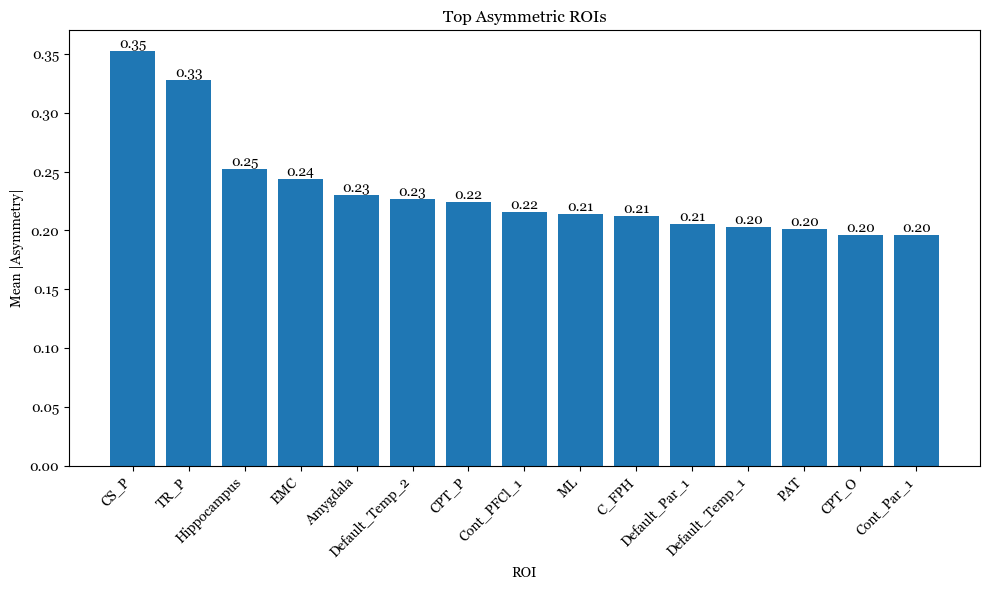

In [ ]:
def plot_top_n_asymmetric_rois(asymmetry_dict, n=5, title="Top Asymmetric ROIs"):
    """
    Plots the top n most asymmetric ROIs on average across subjects.

    Parameters:
    - asymmetry_dict: dict, {subject: {roi: asymmetry_value}}
    - n: int, number of top ROIs to plot
    - title: str, plot title
    """
    # Collect all ROIs
    all_rois = set()
    for sub in asymmetry_dict:
        all_rois.update(asymmetry_dict[sub].keys())
    all_rois = list(all_rois)

    # Compute mean absolute asymmetry for each ROI across subjects
    roi_asymmetry_means = {}
    for roi in all_rois:
        values = []
        for sub in asymmetry_dict:
            if roi in asymmetry_dict[sub]:
                values.append(abs(asymmetry_dict[sub][roi]))
        if values:
            roi_asymmetry_means[roi] = np.mean(values)

    # Sort ROIs by mean absolute asymmetry
    sorted_rois = sorted(roi_asymmetry_means.items(), key=lambda x: x[1], reverse=True)
    top_rois = [roi for roi, _ in sorted_rois[:n]]

    # Prepare data for plotting
    means = [roi_asymmetry_means[roi] for roi in top_rois]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(top_rois, means, capsize=5)
    plt.ylabel("Mean |Asymmetry|")
    plt.xlabel("ROI")
    plt.title(title)
    plt.xticks(rotation=45, ha="right")

    # Add text labels for each ROI
    for roi, mean in zip(top_rois, means):
        plt.text(roi, mean, f"{mean:.2f}", ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

# Example usage:
plot_top_n_asymmetric_rois(temporal_asymmetry_dict, n=15)